# SVM Kernels

## Data Use Agreements
The data used for this project were provided in part by OASIS and ADNI.

OASIS-3: Principal Investigators: T. Benzinger, D. Marcus, J. Morris; NIH P50 AG00561, P30 NS09857781, P01 AG026276, P01 AG003991, R01 AG043434, UL1 TR000448, R01 EB009352. AV-45 doses were provided by Avid Radiopharmaceuticals, a wholly owned subsidiary of Eli Lilly.

Data collection for this project was done through the Alzheimer's Disease Neuroimaging Initiative (ADNI) (National Institutes of Health Grant U01 AG024904) and DOD ADNI (Department of Defense award number W81XWH-12-2-0012). ADNI is funded by the National Institute on Aging, the National Institute of Biomedical Imaging and Bioengineering, and through generous contributions from the following: AbbVie, Alzheimer’s Association; Alzheimer’s Drug Discovery Foundation; Araclon Biotech; BioClinica, Inc.; Biogen; Bristol-Myers Squibb Company; CereSpir, Inc.; Cogstate; Eisai Inc.; Elan Pharmaceuticals, Inc.; Eli Lilly and Company; EuroImmun; F. Hoffmann-La Roche Ltd and its affiliated company Genentech, Inc.; Fujirebio; GE Healthcare; IXICO Ltd.; Janssen Alzheimer Immunotherapy Research & Development, LLC.; Johnson & Johnson Pharmaceutical Research & Development LLC.; Lumosity; Lundbeck; Merck & Co., Inc.; Meso Scale Diagnostics, LLC.; NeuroRx Research; Neurotrack Technologies; Novartis Pharmaceuticals Corporation; Pfizer Inc.; Piramal Imaging; Servier; Takeda Pharmaceutical Company; and Transition Therapeutics. The Canadian Institutes of Health Research is providing funds to support ADNI clinical sites in Canada. Private sector contributions are facilitated by the Foundation for the National Institutes of Health (www.fnih.org). The grantee organization is the Northern California Institute for Research and Education, and the study is coordinated by the Alzheimer’s Therapeutic Research Institute at the University of Southern California. ADNI data are disseminated by the Laboratory for Neuro Imaging at the University of Southern California.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

from tqdm.notebook import tqdm
np.set_printoptions(linewidth=200, suppress=True, formatter={'float': lambda x: "{0:0.3f}".format(x)})

In [2]:
df = pd.read_csv('/hdd/Polygence/Data/OASIS/csv_files/oasis_3.csv')
print(df.shape)

(2168, 22)


In [3]:
df.head()

,Subject,MR ID,id,Age,M/F,dx1,mmse,cdr,apoe,TOTAL_HIPPOCAMPUS_VOLUME,...,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
0,OAS30001,OAS30001_MR_d3132,OAS30001_Freesurfer53_d3132,73.0,F,Cognitively normal,30.0,0.0,23.0,6861.9,...,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
1,OAS30001,OAS30001_MR_d0129,OAS30001_Freesurfer53_d0129,65.0,F,Cognitively normal,30.0,0.0,23.0,7678.9,...,187528.786036,379446.180091,50687.0,517683.180091,8.105851e+05,184600.488060,182662.445419,367262.933479,70168.1,69483.8
2,OAS30001,OAS30001_MR_d2430,OAS30001_Freesurfer53_d2430,71.0,F,Cognitively normal,30.0,0.0,23.0,7105.9,...,178872.680224,357784.489639,49058.0,487405.489639,7.779313e+05,175955.968883,178172.812666,354128.781549,67905.7,68000.2
3,OAS30001,OAS30001_MR_d0757,OAS30001_Freesurfer53_d0757,67.0,F,Cognitively normal,29.0,0.0,23.0,7648.2,...,177566.874682,362040.150904,50071.0,500699.150904,7.993419e+05,185224.779932,188151.990316,373376.770247,69142.3,68558.8
4,OAS30002,OAS30002_MR_d2345,OAS30002_Freesurfer53_d2345,73.0,M,Cognitively normal,29.0,0.0,34.0,7833.2,...,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3


## Data Preprocessing

In [4]:
df = df.dropna(axis=1, how='all') # Drop any empty columns
df = df.dropna(axis=0, how='any') # Drop any rows with empty values 
df = df.rename(columns={'id':'Freesurfer ID', 'dx1':'Diagnosis', 
                        'TOTAL_HIPPOCAMPUS_VOLUME':'TotalHippocampusVol'}) # Rename columns
df = df.drop_duplicates(subset='Subject', keep='first') # Keep only the first visit; this is possible because
                                                        # df is sorted by age
df = df.reset_index(drop=True) # Reset the index
df = df.set_index('Subject')
cols = df.columns.tolist()
cols[2], cols[4] = cols[4], cols[2]
df = df[cols]
df.loc[df['cdr'] < 0.5, 'Diagnosis'] = 'CN'
df.loc[~(df['cdr'] < 0.5), 'Diagnosis'] = 'AD'
df['M/F'].replace(['M','F'], [0,1], inplace=True)
df = df.drop(['MR ID', 'Freesurfer ID', 'cdr'], axis=1) # Drop categorical and redundant columns
print(df.shape)

(1022, 18)


In [5]:
df.head()

,Diagnosis,M/F,Age,mmse,apoe,TotalHippocampusVol,IntraCranialVol,lhCortexVol,rhCortexVol,CortexVol,SubCortGrayVol,TotalGrayVol,SupraTentorialVol,lhCorticalWhiteMatterVol,rhCorticalWhiteMatterVol,CorticalWhiteMatterVol,L.SurfArea,R.SurfArea
Subject,,,,,,,,,,,,,,,,,,
OAS30001,CN,1,73.0,30.0,23.0,6861.9,1.186091e+06,181943.698754,178031.558882,359975.257636,48400.0,491102.257636,7.736716e+05,174372.329393,173244.012238,347616.341631,67598.1,67185.8
OAS30002,CN,0,73.0,29.0,34.0,7833.2,1.714636e+06,227101.503019,230240.532783,457342.035802,56773.0,607473.035802,1.051714e+06,239168.338419,245361.377267,484529.715686,83138.1,85742.3
OAS30003,CN,1,66.0,29.0,33.0,7983.5,1.405092e+06,204825.718573,209641.219733,414466.938306,59379.0,557900.938306,9.299305e+05,213905.159729,222232.368895,436137.528624,76695.5,78697.9
OAS30004,CN,1,61.0,30.0,23.0,8525.1,1.443177e+06,213861.671106,206884.661369,420746.332475,53910.0,566477.332475,9.709780e+05,242595.702097,233016.992108,475612.694206,87710.1,84634.9
OAS30005,CN,1,54.0,30.0,33.0,9298.2,1.554566e+06,225743.655875,224311.450543,450055.106418,63545.0,611117.106418,9.867349e+05,229534.963360,230927.823126,460462.786487,82224.0,81421.3


In [6]:
groups = df.groupby('Diagnosis')
gr_CN = groups.get_group('CN')
gr_AD = groups.get_group('AD')

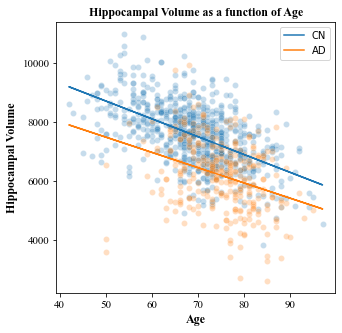

In [11]:
tnrfont = {'fontname':'Times New Roman',
          'weight':'bold',
          'fontsize':'large'}
fig, ax = plt.subplots(figsize=(5,5))

sns.scatterplot(ax=ax, data=gr_CN, x='Age', y='TotalHippocampusVol', alpha=0.25)
sns.scatterplot(ax=ax, data=gr_AD, x='Age', y='TotalHippocampusVol', alpha=0.25)

ax.set_xlabel('Age', **tnrfont)
ax.set_ylabel('Hippocampal Volume', **tnrfont)
ax.set_title('Hippocampal Volume as a function of Age', **tnrfont)

for label in ax.get_xticklabels():
    label.set_fontproperties('Times New Roman')

for label in ax.get_yticklabels():
    label.set_fontproperties('Times New Roman')
    
plt.yticks(fontsize=11)
plt.xticks(fontsize=11)



sns.despine(fig=None, ax=ax, top=False, right=False, left=False, 
            bottom=False, offset=None, trim=False)

m, b = np.polyfit(gr_CN['Age'], gr_CN['TotalHippocampusVol'], 1)
ax.plot(gr_CN['Age'], m*gr_CN['Age'] + b, label='CN')

m, b = np.polyfit(gr_AD['Age'], gr_AD['TotalHippocampusVol'], 1)
ax.plot(gr_CN['Age'], m*gr_CN['Age'] + b, label='AD')
ax.legend()

plt.savefig('hipvage.png', bbox_inches='tight',
            pad_inches=0.3)